# Intorduction: Support Vector Machines (SVM) "from Scratch"
---
Support Vector Machine from first principles (from scratch). The sections of this notebook include:

two synthetic balanced datasets with 100 samples
1.   Linear separable Dataset
2.   Non Linear separable Dataset



My full implementaiton of the SVM model incluiding all kernel funcitons (Linear, RBF, Polynomial, Sigmoid) -> enabling the kernel trick.
* Linear kernel used for linear dataset
* Non linear kernels RBF, Polynomial, Sigmoid used on non linear dataset
* training functions/optimisation algorithms:

1.   Primal optimisaiton problem solved via Stochastic Gradient Descent (SGD) for linear kernel
2.   Dual Optimisation problem solved via Sequential Minimal Optimization (SMO)
for non-linear kernels

* Prediciton and Decision Funciton
* Appropariate Evaluation functions to produce qualitative and quantitative metrics


---
# Further Study: How Noise effects SVM Peformance & Potential Improvements?

Following the implementation, I will attempt to address the **limitation of SVM's senstitivity to noise**, via studying how noise effects the model's peformance to distinguish decision boundaries and how datasets with noise can be potentially improved via these tests

* **Test 1**: Test kernels on a non-noisy/perfect dataset
* **Test 2**: Test Kernels on a noisy dataset (0.2 noise)
* **Test 3**: Test Kernels on a noisy dataset (0.2 noise) and tune the hyperparameters via **grid search**
* **Test 4**: Test Kernels on a noisy dataset (0.2 noise) and tune the hyperparameter via **random search**

all kernels will be tested in each test and their accuracy, f1 score and AUC-ROC metrics will be compared to provide insights on the effect of noise.

# SVM Implementation

## Libraries used

In [ ]:
# Import relevent libraries
import numpy as np
import matplotlib.pyplot as plt
import random

## SVM class

Implements all components and functionalities needed to simulate a SVM Model


In [ ]:
class SVM:
    def __init__(self, kernel='linear', C=1.0, tol=1e-4, max_passes=10, max_iter=1000, gamma=0.1, degree=3):
        # Initialize SVM parameters
        self.kernel = kernel  # Type of Kernel (linear, rbf, polynomial, sigmoid)
        self.C = C            # regularization parameter (controls tradeoff betwwn margin and violation)
        self.tol = tol        # tolerance for stopping criteria in SMO
        self.max_passes = max_passes  # SMO : max passes to check alphas
        self.max_iter = max_iter  # SGD : mac number of iterations
        self.gamma = gamma    # kernel coefficient for RBF
        self.degree = degree  # degree for polynomial kernel
        self.alpha = None     # Lagrange multipliers (for SMO)
        self.b = 0            # bias term
        self.w = None         # weights for linear SVM (for SGD)
        self.X = None         # store training data (needed for kernel trick)
        self.y = None         # store labels

#-------------------------------------Kerenls-----------------------------------#
    def linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def polynomial_kernel(self, X1, X2):
        return (1 + np.dot(X1, X2.T)) ** self.degree

    def rbf_kernel(self, X1, X2):
        #handle differnt input dimensions
        if X1.ndim == 1 and X2.ndim == 1:
            return np.exp(-self.gamma * np.linalg.norm(X1 - X2) ** 2)
        elif X1.ndim > 1 and X2.ndim > 1:
            return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2, axis=2) ** 2)
        else:
            return np.exp(-self.gamma * np.linalg.norm(X1 - X2, axis=1) ** 2)

    def sigmoid_kernel(self, X1, X2):
        return np.tanh(np.dot(X1, X2.T))

    #initialises the approiate kernel function
    def compute_kernel(self, X1, X2):
        if self.kernel == 'linear':
            return self.linear_kernel(X1, X2)
        elif self.kernel == 'polynomial':
            return self.polynomial_kernel(X1, X2)
        elif self.kernel == 'rbf':
            return self.rbf_kernel(X1, X2)
        elif self.kernel == 'sigmoid':
            return self.sigmoid_kernel(X1, X2)
        else:
            raise ValueError("Unknown kernel")

#-----------------------------Training Functions-------------------------------#

    # Define the Stochastic Gradient Descent (SGD) optimiser to solve primal optimisaiton problem for linear kernel
    def fit_sgd(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features) #initialise weight vector
        self.b = 0                    #intialise Bias
        learning_rate = 0.01          # Learning rate
        lambda_ = 0.01                # Regularization

        # Iterate the max iterations for all samples
        for _ in range(self.max_iter):
            for i in range(n_samples):
                #hinge loss function
                condition = y[i] * (np.dot(self.w, X[i]) + self.b) >= 1
                if condition:  # No violation, no hinge loss penalty
                    self.w -= learning_rate * (2 * lambda_ * self.w)  # regularize weights
                else:  # Violation, update using hinge loss
                    self.w -= learning_rate * (2 * lambda_ * self.w - np.dot(X[i], y[i]))
                    self.b += learning_rate * y[i]  # Update bias

    # Sequential Minimal Optimisation (SMO) optimizer to solve Dual Optimisaiton problem for non-linear kernels
    # employs the "kernel trick"
    def fit_smo(self, X, y):
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples) #initialise Lagrange multipliers
        self.b = 0                       #initialise bias
        self.X = X                       # Store training data
        self.y = y                       # Store labels
        passes = 0                       # Keep track of passes with no alpha changes

        #compute the decision for smaple i
        def decision_function(i):
            kernel_result = self.compute_kernel(X, X[i])
            return np.sum(self.alpha * y * kernel_result) + self.b

        #iterate until max passes or convergence
        while passes < self.max_passes:
            num_changed_alphas = 0
            for i in range(n_samples):
                E_i = decision_function(i) - y[i]
                if (y[i] * E_i < -self.tol and self.alpha[i] < self.C) or (y[i] * E_i > self.tol and self.alpha[i] > 0):
                    j = np.random.randint(0, n_samples)
                    if j == i:
                        continue
                    E_j = decision_function(j) - y[j]

                    alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]

                    # Compute bounds for alpha[j]
                    if y[i] != y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])

                    if L == H:
                        continue

                    # Compute eta (sensitvity of objective to alpha changes)
                    eta = 2 * self.compute_kernel(X[i], X[j]) - self.compute_kernel(X[i], X[i]) - self.compute_kernel(X[j], X[j])
                    if eta >= 0:
                        continue

                    # Update alpha[j]
                    self.alpha[j] -= y[j] * (E_i - E_j) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)

                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue

                    # Update alpha[i]
                    self.alpha[i] += y[i] * y[j] * (alpha_j_old - self.alpha[j])

                    # Compute new bias terms
                    b1 = self.b - E_i - y[i] * (self.alpha[i] - alpha_i_old) * self.compute_kernel(X[i], X[i]) - y[j] * (self.alpha[j] - alpha_j_old) * self.compute_kernel(X[i], X[j])
                    b2 = self.b - E_j - y[i] * (self.alpha[i] - alpha_i_old) * self.compute_kernel(X[i], X[j]) - y[j] * (self.alpha[j] - alpha_j_old) * self.compute_kernel(X[j], X[j])

                    #dual optimisation constraint
                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    num_changed_alphas += 1

            #determine whether to continue or stop
            passes = passes + 1 if num_changed_alphas == 0 else 0

    # train SVM model , with appropaite optimisation algorithm for kernel type
    def fit(self, X, y):
        if self.kernel == 'linear':
            self.fit_sgd(X, y)
        else:
            self.fit_smo(X, y)

#------------------------------Testing Functions-------------------------------#

    #calculate output for each input X
    def decision_function(self, X):
      if self.kernel == 'linear':
          return np.dot(X, self.w) + self.b
      else:
          return np.array([np.sum(self.alpha * self.y * self.compute_kernel(self.X, x)) + self.b for x in X])

    #predict class labels
    def predict(self, X):
      decision_values = self.decision_function(X)
      return np.sign(decision_values)

#----------------------------Evaluation Funcitons------------------------------#

    #compute accuracy by comparing predictions with true labels
    def accuracy(self, X, y):
      predictions = self.predict(X)
      return np.mean(predictions == y)

    #compute the hinge loss (not linked in SGD & SMO, as is implicitly implemented)
    def hinge_loss(self, X, y):
        hinge_loss = 0
        if self.kernel == 'linear':
            # For linear kernel, use the normal hinge loss
            for i in range(len(X)):
                hinge_loss += max(0, 1 - y[i] * (np.dot(self.w, X[i]) + self.b))
        else:
            # For non-linear kernels (e.g., RBF), compute hinge loss using the kernel trick
            for i in range(len(X)):
                prediction = np.sum(self.alpha * self.y * self.compute_kernel(self.X, X[i])) + self.b
                hinge_loss += max(0, 1 - y[i] * prediction)

        return hinge_loss / len(X)





## Helper funcitons

In [ ]:
# Helper function to generate synthetic datasets
def generate_data(linear=True, n_samples=100, noise_level=0):
    np.random.seed(42)
    if linear:
        # Linear separable dataset (Dataset A)
        X = np.random.randn(n_samples, 2)
        y = np.sign(X[:, 0] + X[:, 1])  # simple linear boundary
    else:
        # Non-linear separable dataset (Dataset B)
        X = np.random.randn(n_samples, 2)
        y = np.sign(X[:, 0] ** 2 + X[:, 1] ** 2 - 1)  # circular boundary

    # Add noise to the data
    noise = np.random.normal(0, noise_level, X.shape)  # Gaussian noise
    X += noise  # Add noise to the feature values

    return X, y

# Train-test split function
def train_test_split(X, y, test_size=0.2): #default 80%(training), 20%(test)
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    split_index = int(n_samples * (1 - test_size))
    train_idx, test_idx = indices[:split_index], indices[split_index:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Plot the generated data without the decision boundary
def plot_dataset(X, y, title="Dataset"):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30)
    plt.title(title)
    plt.show()

# Plot the generated data with the decision boundary
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    # Create grid to evaluate model
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Predict class over the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.title(title)
    plt.show()


# Evaluation & Hyperparameter Tuning Functions

## Evaluating Functions

In [ ]:
def calculate_confusion_matrix(y_true, y_pred):
    # Assuming binary classification with labels -1 and 1
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        if t == 1 and p == 1:
            cm[0, 0] += 1  # True Positive
        elif t == 1 and p == -1:
            cm[0, 1] += 1  # False Negative
        elif t == -1 and p == 1:
            cm[1, 0] += 1  # False Positive
        elif t == -1 and p == -1:
            cm[1, 1] += 1  # True Negative
    return cm

#plots the calculates confusion matrix
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=[0, 1], yticks=[0, 1],
           xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

#calculates evaluation metrics : accuracy, precision, recall and F1 score
def calculate_metrics(y_true, y_pred):
    cm = calculate_confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score

#calculates the ROC-AUC metric
def calculate_roc_auc(y_true, y_scores):
    # Sort by the predicted scores in descending order
    sorted_indices = np.argsort(-y_scores)
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]

    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    tpr_values = []
    fpr_values = []
    num_positive = np.sum(y_true == 1)
    num_negative = np.sum(y_true == -1)
    tp = 0
    fp = 0

    for i in range(len(y_true)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1

        tpr = tp / num_positive if num_positive > 0 else 0
        fpr = fp / num_negative if num_negative > 0 else 0

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Calculate the AUC using the trapezoidal rule
    auc = 0
    for i in range(1, len(fpr_values)):
        auc += (fpr_values[i] - fpr_values[i - 1]) * (tpr_values[i] + tpr_values[i - 1]) / 2

    return auc

#summarises the evaluation metrics to a report
def print_classification_report(y_true, y_pred, name):
    accuracy, precision, recall, f1_score = calculate_metrics(y_true, y_pred)

    print("Classification Report: " + name)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1_score:.4f}")


## Hyperparameter Tuning techniques



*   **Grid Search** : A hyperparameter tuning technique that exhaustively tests all combinations of predefined parameter values to identify the best-performing configuration for a model.
*   **Random Search** : A hyperparameter tuning technique that randomly samples a subset of hyperparameter combinations within specified ranges, exploring a broader search space more efficiently than grid search.



In [ ]:
#-------------------------------------------GridSearch-----------------------------------------------------------#
def grid_search_svm(X_train, y_train, X_val, y_val, kernel, C_range, gamma_range=None, degree_range=None, num_samples=5):
    best_accuracy = 0
    best_C = None
    best_gamma = None
    best_degree = None

    # Generate the grid of C values
    C_values = np.logspace(np.log10(C_range[0]), np.log10(C_range[1]), num_samples)

    # Prepare grid search for gamma (for RBF) or degree (for Polynomial)
    if gamma_range and kernel == 'rbf':
        gamma_values = np.logspace(np.log10(gamma_range[0]), np.log10(gamma_range[1]), num_samples)
    else:
        gamma_values = [None] * num_samples

    if degree_range and kernel == 'polynomial':
        degree_values = range(degree_range[0], degree_range[1] + 1)
    else:
        degree_values = [None] * num_samples

    # Iterate over all combinations of hyperparameters
    for C in C_values:
        for gamma in gamma_values:
            for degree in degree_values:
                # Skip combinations that are not applicable (e.g., gamma for linear or degree for RBF)
                if (kernel == 'rbf' and gamma is None) or (kernel == 'polynomial' and degree is None):
                    continue

                # Create the SVM model based on the kernel and hyperparameters
                model = SVM(kernel=kernel, C=C, gamma=gamma, degree=degree)
                model.fit(X_train, y_train)

                # Evaluate accuracy on the validation set
                accuracy = model.accuracy(X_val, y_val)

                # Track the best hyperparameters
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_C = C
                    best_gamma = gamma
                    best_degree = degree

    print(f"Best C: {best_C}, Best Gamma: {best_gamma}, Best Degree: {best_degree} with accuracy: {best_accuracy}")
    return best_C, best_gamma, best_degree, best_accuracy

#-------------------------------------------RandomSearch-----------------------------------------------------------#

def random_search_svm(X_train, y_train, X_val, y_val, kernel, C_range, gamma_range=None, degree_range=None, num_samples=5):
    best_accuracy = 0
    best_C = None
    best_gamma = None
    best_degree = None

    # Randomly sample `num_samples` values of C from the given C_range
    random_C_values = [random.uniform(C_range[0], C_range[1]) for _ in range(num_samples)]

    if gamma_range:
        random_gamma_values = [random.uniform(gamma_range[0], gamma_range[1]) for _ in range(num_samples)]
    else:
        random_gamma_values = [None] * num_samples

    if degree_range:
        random_degree_values = [random.randint(degree_range[0], degree_range[1]) for _ in range(num_samples)]
    else:
        random_degree_values = [None] * num_samples

    # Iterate over the random values for C, gamma, and degree
    for i in range(num_samples):
        C = random_C_values[i]
        gamma = random_gamma_values[i] if gamma_range else None
        degree = random_degree_values[i] if degree_range else None

        # Create the SVM model based on the kernel and hyperparameters
        model = SVM(kernel=kernel, C=C, gamma=gamma, degree=degree)
        model.fit(X_train, y_train)

        # Evaluate accuracy
        accuracy = model.accuracy(X_val, y_val)

        # Track the best hyperparameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_C = C
            best_gamma = gamma
            best_degree = degree

    print(f"Best C: {best_C}, Best Gamma: {best_gamma}, Best Degree: {best_degree} with accuracy: {best_accuracy}")
    return best_C, best_gamma, best_degree, best_accuracy

# Noise Tests

## Test 1: Applying models on no noise dataset


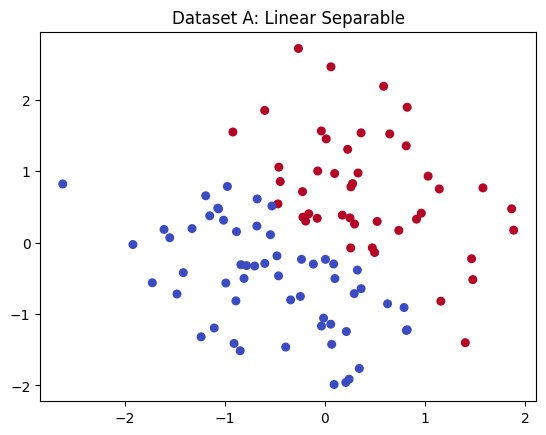

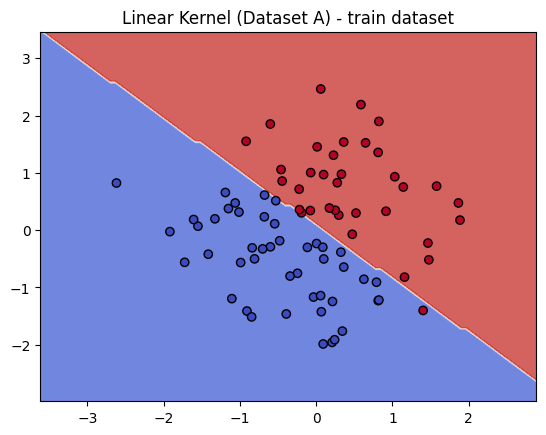

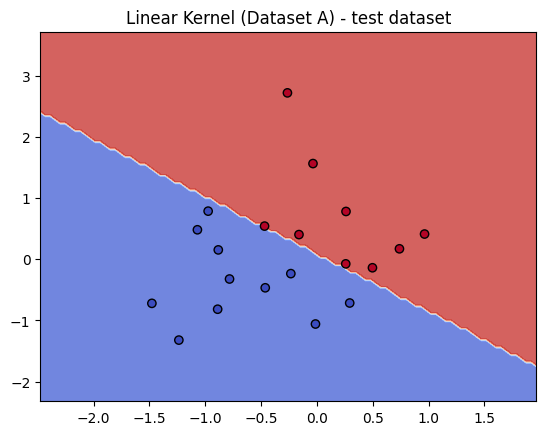

****************************************************************************************************************************************************************


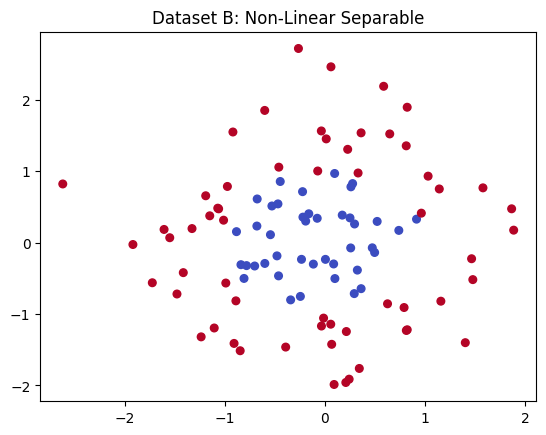

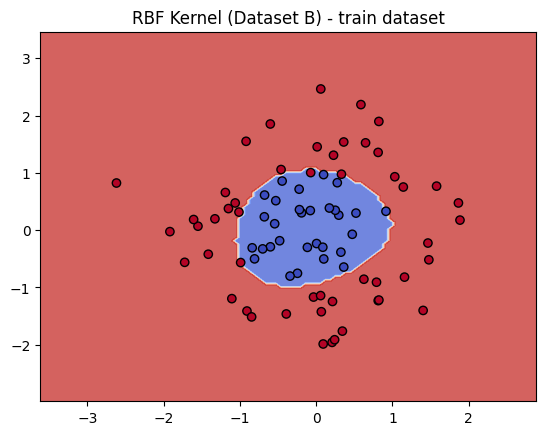

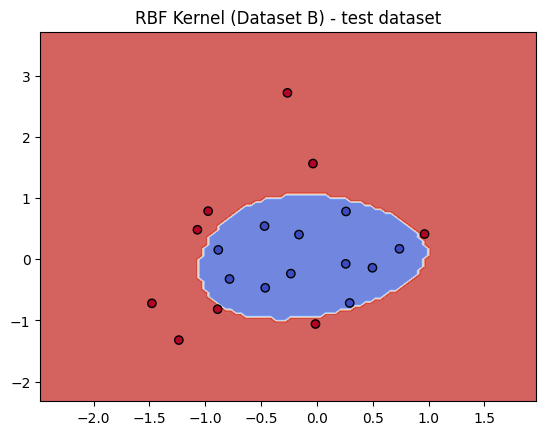

****************************************************************************************************************************************************************


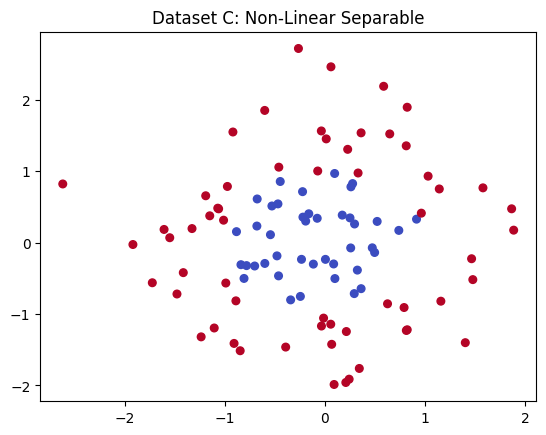

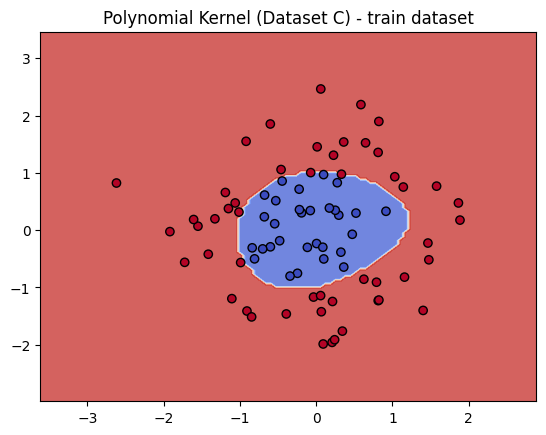

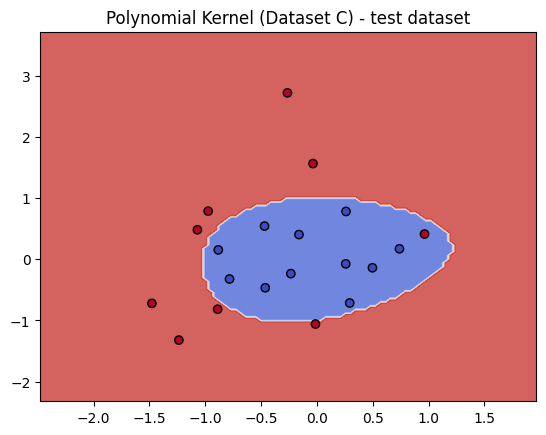

****************************************************************************************************************************************************************


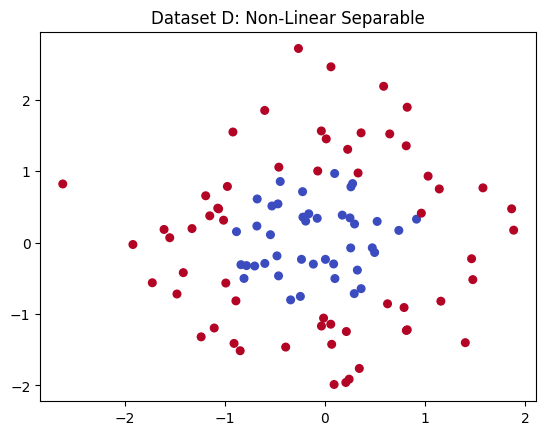

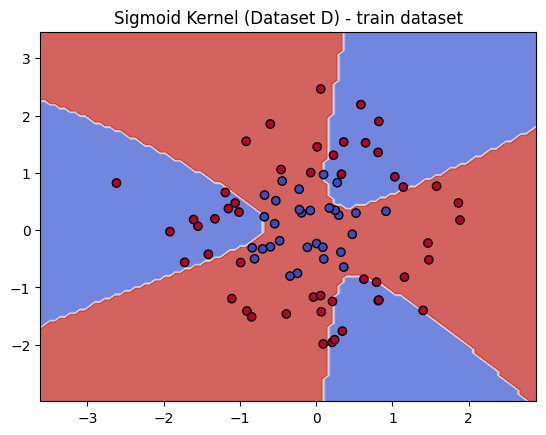

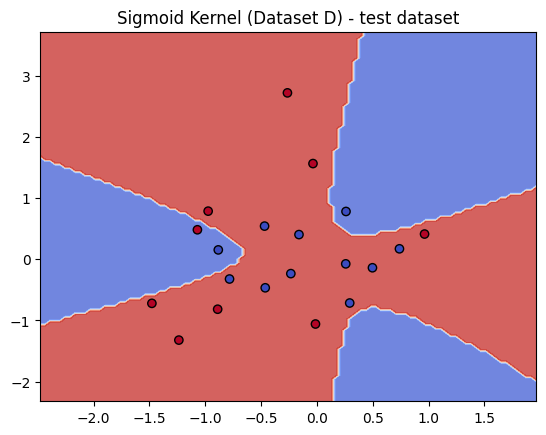

In [ ]:
#-------------------------------------------Linear-----------------------------------------------------------#
# Dataset A: Linear separable
X_A, y_A = generate_data(linear=True, noise_level=0.0)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A)

# Train SVM on Dataset A (Linear) using SGD
svm_linear = SVM(kernel='linear')
svm_linear.fit(X_train_A, y_train_A)

# Generate and plot Dataset A (Linear)
X_A, y_A = generate_data(linear=True, noise_level=0.0)
plot_dataset(X_A, y_A, title="Dataset A: Linear Separable")

# Plot decision boundary for Dataset A
plot_decision_boundary(svm_linear, X_train_A, y_train_A, title="Linear Kernel (Dataset A) - train dataset")

# Plot decision boundary for Dataset A (Linear)
plot_decision_boundary(svm_linear, X_test_A, y_test_A, title="Linear Kernel (Dataset A) - test dataset")

print("*" * 160)
#--------------------------------------------RBF-------------------------------------------------------------#

# Dataset B: Non-linear separable
X_B, y_B = generate_data(linear=False, noise_level=0.0)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B)

# Train SVM on Dataset B (Non-linear) using SMO with RBF kernel
svm_rbf = SVM(kernel='rbf', C=1.0, gamma=0.5)
svm_rbf.fit(X_train_B, y_train_B)

# Generate and plot Dataset B (Non-Linear)
X_B, y_B = generate_data(linear=False, noise_level=0.0)
plot_dataset(X_B, y_B, title="Dataset B: Non-Linear Separable")

# Plot decision boundary for Dataset B
plot_decision_boundary(svm_rbf, X_train_B, y_train_B, title="RBF Kernel (Dataset B) - train dataset")

# Plot decision boundary for Dataset B (RBF Kernel)
plot_decision_boundary(svm_rbf, X_test_B, y_test_B, title="RBF Kernel (Dataset B) - test dataset")

print("*" * 160)
#--------------------------------------------Polynomial--------------------------------------------------------#

# Dataset C: Non-linear separable
X_C, y_C = generate_data(linear=False, noise_level=0.0)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C)

# Train SVM on Dataset B (Non-linear) using SMO with Polynomial kernel
svm_polynomial = SVM(kernel='polynomial', C=1.0)
svm_polynomial.fit(X_train_C, y_train_C)

# Generate and plot Dataset B (Non-Linear)
X_C, y_C = generate_data(linear=False, noise_level=0.0)
plot_dataset(X_C, y_C, title="Dataset C: Non-Linear Separable")

# Plot decision boundary for Dataset B
plot_decision_boundary(svm_polynomial, X_train_C, y_train_C, title="Polynomial Kernel (Dataset C) - train dataset")

# Plot decision boundary for Dataset B (Polynomial Kernel)
plot_decision_boundary(svm_polynomial, X_test_C, y_test_C, title="Polynomial Kernel (Dataset C) - test dataset")

print("*" * 160)
#---------------------------------------------Sigmoid----------------------------------------------------------#

# Dataset D: Non-linear separable
X_D, y_D = generate_data(linear=False, noise_level=0.0)
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X_D, y_D)

# Train SVM on Dataset D (Non-linear) using SMO with Sigmoid kernel
svm_sigmoid = SVM(kernel='sigmoid', C=1.0)
svm_sigmoid.fit(X_train_D, y_train_D)

# Generate and plot Dataset D (Non-Linear)
X_D, y_D = generate_data(linear=False, noise_level=0.0)
plot_dataset(X_D, y_D, title="Dataset D: Non-Linear Separable")

# Plot decision boundary for Dataset D
plot_decision_boundary(svm_sigmoid, X_train_D, y_train_D, title="Sigmoid Kernel (Dataset D) - train dataset")

# Plot decision boundary for Dataset D (Sigmoid Kernel)
plot_decision_boundary(svm_sigmoid, X_test_D, y_test_D, title="Sigmoid Kernel (Dataset D) - test dataset")

**Visualise Classification Report and Confusion Matrix for kernels on selected test**

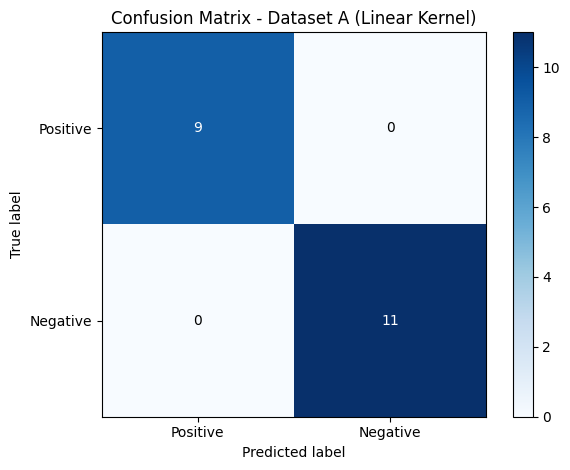

Classification Report: Dataset A (Linear Kernel)
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
AUC:       1.0000
Hinge Loss: 0.1796


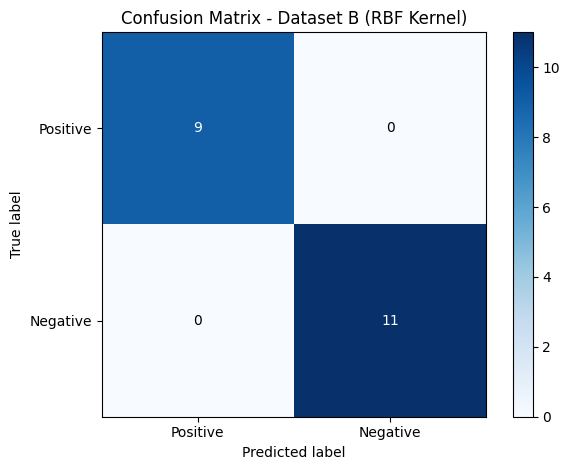

Classification Report: Dataset B (RBF Kernel)
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
AUC:       1.0000
Hinge Loss: 0.2906


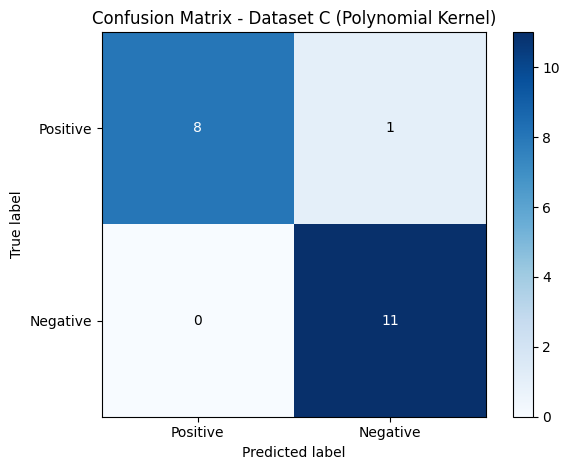

Classification Report: Dataset C (Polynomial Kernel)
Accuracy:  0.9500
Precision: 0.9167
Recall:    1.0000
F1 Score:  0.9565
AUC:       1.0000
Hinge Loss: 0.1577


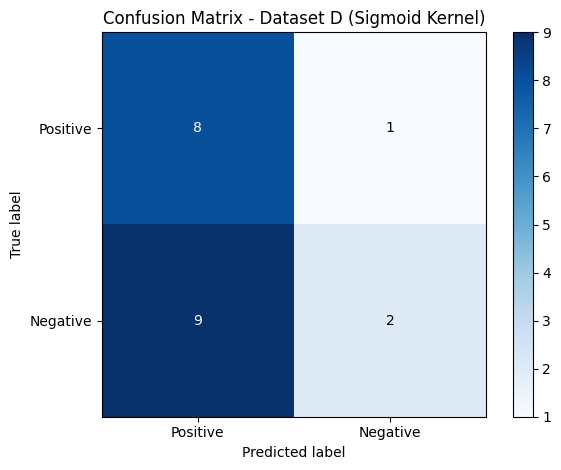

Classification Report: Dataset D (Sigmoid Kernel)
Accuracy:  0.5000
Precision: 0.6667
Recall:    0.1818
F1 Score:  0.2857
AUC:       0.6263
Hinge Loss: 1.3161


In [ ]:
#-------------------------------------------Linear-----------------------------------------------------------#
# Visualize results for Linear kernel on dataset A
y_pred_A = svm_linear.predict(X_test_A)
cm_A = calculate_confusion_matrix(y_test_A, y_pred_A)
plot_confusion_matrix(cm_A, "Confusion Matrix - Dataset A (Linear Kernel)")
print_classification_report(y_test_A, y_pred_A, "Dataset A (Linear Kernel)")

auc_value = calculate_roc_auc(y_test_A, svm_linear.decision_function(X_test_A))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_A = svm_linear.hinge_loss(X_test_A, y_test_A)
print(f"Hinge Loss: {test_hinge_loss_A:.4f}")
#-------------------------------------------RBF--------------------------------------------------------------#
# Visualize results for RBF kernel on Dataset B
y_pred_B = svm_rbf.predict(X_test_B)
cm_B = calculate_confusion_matrix(y_test_B, y_pred_B)
plot_confusion_matrix(cm_B, "Confusion Matrix - Dataset B (RBF Kernel)")
print_classification_report(y_test_B, y_pred_B, "Dataset B (RBF Kernel)")

auc_value = calculate_roc_auc(y_test_B, svm_rbf.decision_function(X_test_B))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_B = svm_rbf.hinge_loss(X_test_B, y_test_B)
print(f"Hinge Loss: {test_hinge_loss_B:.4f}")

#-------------------------------------------Polynomial--------------------------------------------------------#
# Visualize results for polynomial kernel Dataset B
y_pred_C = svm_polynomial.predict(X_test_C)
cm_C = calculate_confusion_matrix(y_test_C, y_pred_C)
plot_confusion_matrix(cm_C, "Confusion Matrix - Dataset C (Polynomial Kernel)")
print_classification_report(y_test_C, y_pred_C, "Dataset C (Polynomial Kernel)")

auc_value = calculate_roc_auc(y_test_C, svm_polynomial.decision_function(X_test_C))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_C = svm_polynomial.hinge_loss(X_test_C, y_test_C)
print(f"Hinge Loss: {test_hinge_loss_C:.4f}")
#-------------------------------------------Sigmoid-----------------------------------------------------------#
# Visualize results for sigmoid kernel on Dataset B
y_pred_D = svm_sigmoid.predict(X_test_D)
cm_D = calculate_confusion_matrix(y_test_D, y_pred_D)
plot_confusion_matrix(cm_D, "Confusion Matrix - Dataset D (Sigmoid Kernel)")
print_classification_report(y_test_D, y_pred_D, "Dataset D (Sigmoid Kernel)")

auc_value = calculate_roc_auc(y_test_D, svm_sigmoid.decision_function(X_test_D))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_D = svm_sigmoid.hinge_loss(X_test_D, y_test_D)
print(f"Hinge Loss: {test_hinge_loss_D:.4f}")

## Test 2: Applying models on dataset with noise(0.2)


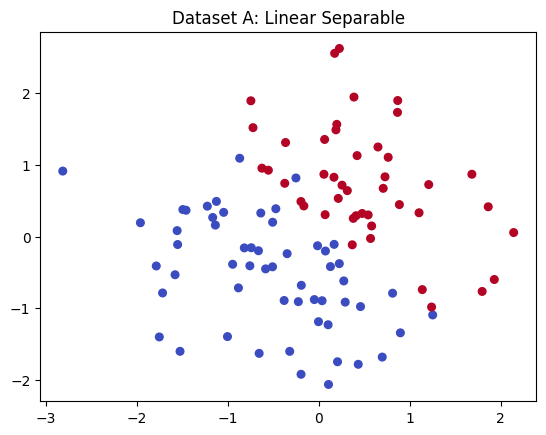

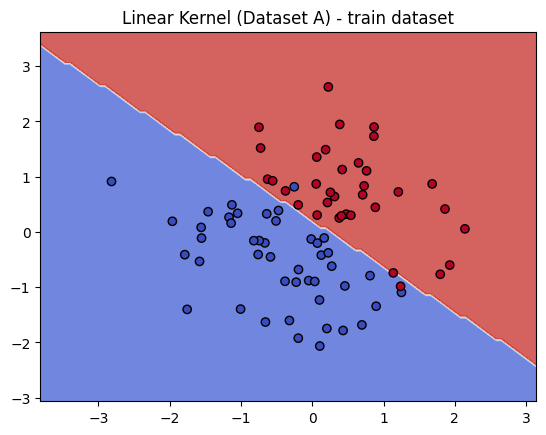

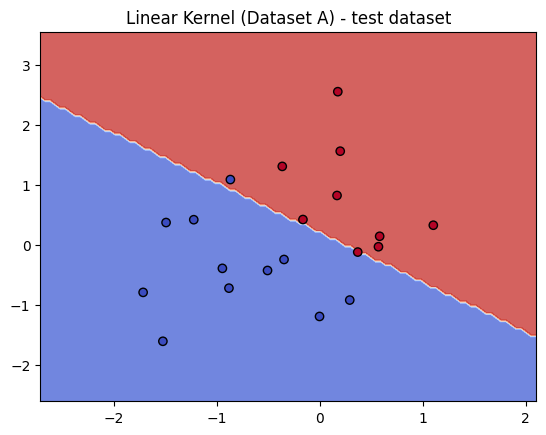

****************************************************************************************************************************************************************


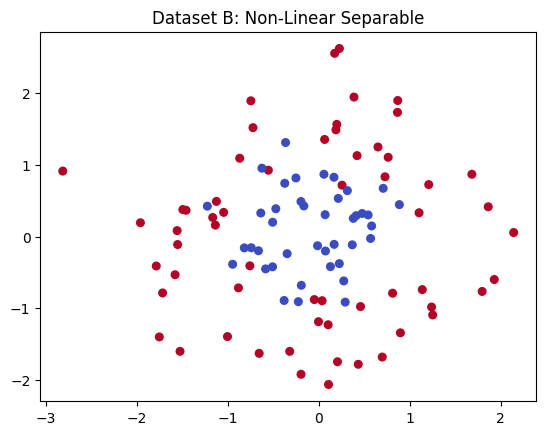

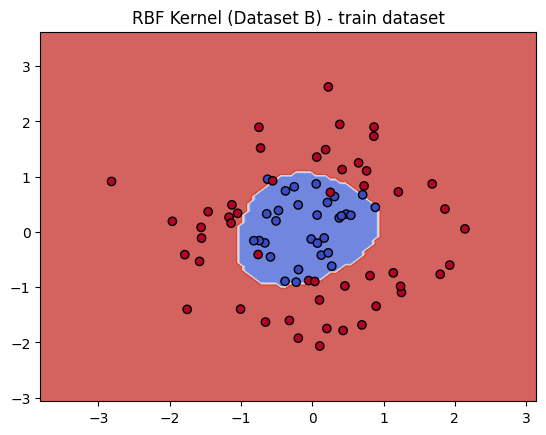

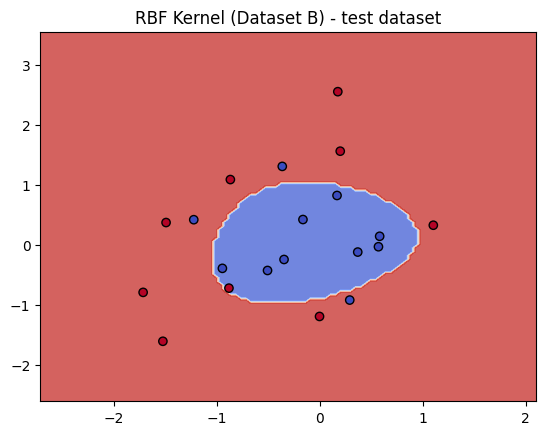

****************************************************************************************************************************************************************


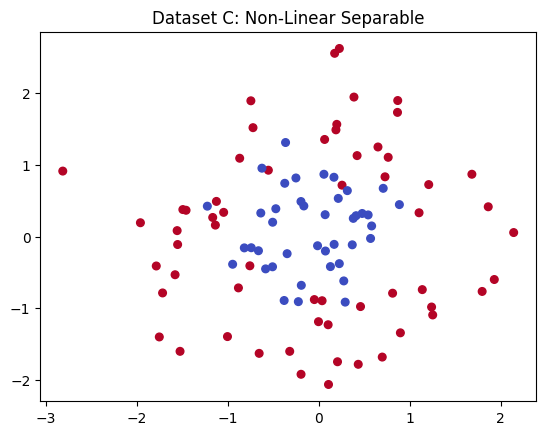

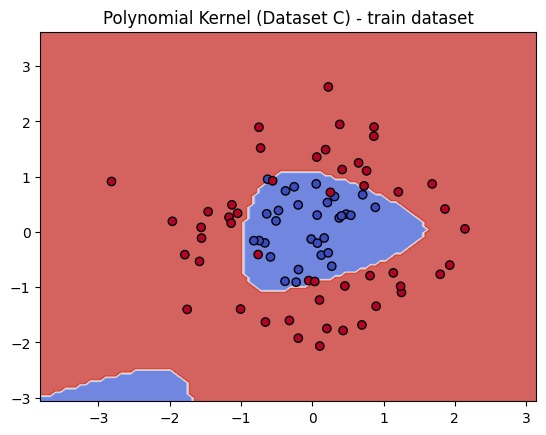

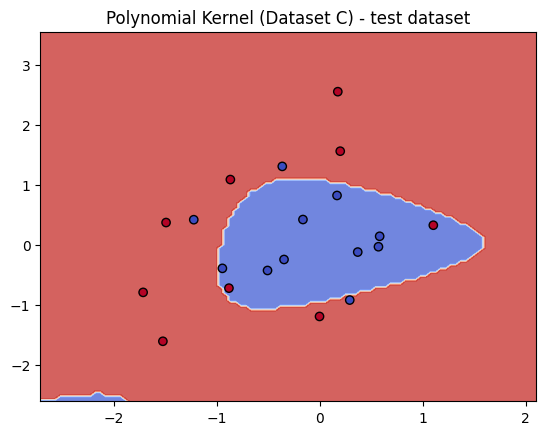

****************************************************************************************************************************************************************


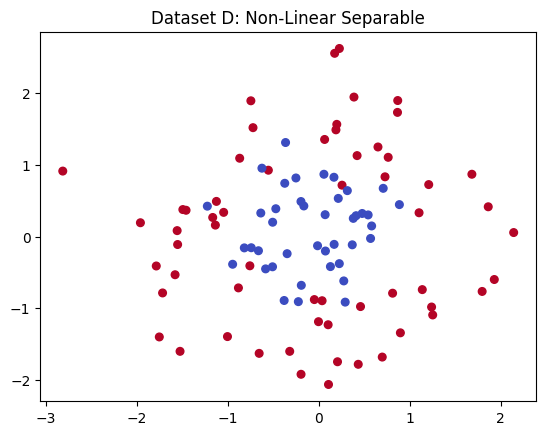

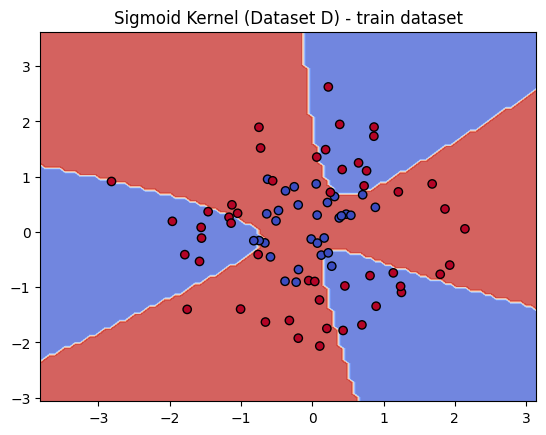

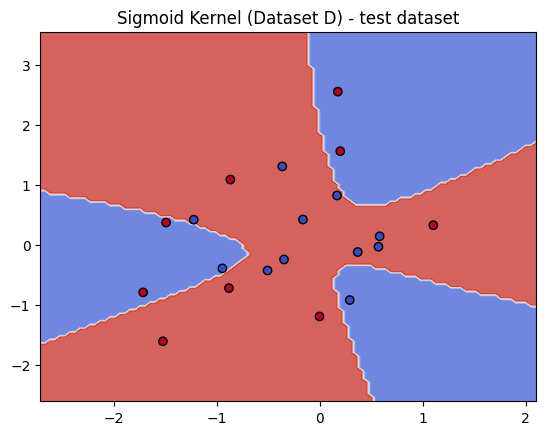

In [ ]:
#-------------------------------------------Linear-----------------------------------------------------------#
# Dataset A: Linear separable
X_A, y_A = generate_data(linear=True, noise_level=0.2)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A)

# Train SVM on Dataset A (Linear) using SGD
svm_linear = SVM(kernel='linear')
svm_linear.fit(X_train_A, y_train_A)

# Generate and plot Dataset A (Linear)
X_A, y_A = generate_data(linear=True, noise_level=0.2)
plot_dataset(X_A, y_A, title="Dataset A: Linear Separable")

# Plot decision boundary for Dataset A
plot_decision_boundary(svm_linear, X_train_A, y_train_A, title="Linear Kernel (Dataset A) - train dataset")

# Plot decision boundary for Dataset A (Linear)
plot_decision_boundary(svm_linear, X_test_A, y_test_A, title="Linear Kernel (Dataset A) - test dataset")

print("*" * 160)
#--------------------------------------------RBF-------------------------------------------------------------#

# Dataset B: Non-linear separable
X_B, y_B = generate_data(linear=False, noise_level=0.2)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B)

# Train SVM on Dataset B (Non-linear) using SMO with RBF kernel
svm_rbf = SVM(kernel='rbf', C=1.0, gamma=0.5)
svm_rbf.fit(X_train_B, y_train_B)

# Generate and plot Dataset B (Non-Linear)
X_B, y_B = generate_data(linear=False, noise_level=0.2)
plot_dataset(X_B, y_B, title="Dataset B: Non-Linear Separable")

# Plot decision boundary for Dataset B
plot_decision_boundary(svm_rbf, X_train_B, y_train_B, title="RBF Kernel (Dataset B) - train dataset")

# Plot decision boundary for Dataset B (RBF Kernel)
plot_decision_boundary(svm_rbf, X_test_B, y_test_B, title="RBF Kernel (Dataset B) - test dataset")

print("*" * 160)
#--------------------------------------------Polynomial--------------------------------------------------------#

# Dataset C: Non-linear separable
X_C, y_C = generate_data(linear=False, noise_level=0.2)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C)

# Train SVM on Dataset B (Non-linear) using SMO with Polynomial kernel
svm_polynomial = SVM(kernel='polynomial', C=1.0)
svm_polynomial.fit(X_train_C, y_train_C)

# Generate and plot Dataset B (Non-Linear)
X_C, y_C = generate_data(linear=False, noise_level=0.2)
plot_dataset(X_C, y_C, title="Dataset C: Non-Linear Separable")

# Plot decision boundary for Dataset B
plot_decision_boundary(svm_polynomial, X_train_C, y_train_C, title="Polynomial Kernel (Dataset C) - train dataset")

# Plot decision boundary for Dataset B (Polynomial Kernel)
plot_decision_boundary(svm_polynomial, X_test_C, y_test_C, title="Polynomial Kernel (Dataset C) - test dataset")

print("*" * 160)
#---------------------------------------------Sigmoid----------------------------------------------------------#

# Dataset D: Non-linear separable
X_D, y_D = generate_data(linear=False, noise_level=0.2)
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X_D, y_D)

# Train SVM on Dataset D (Non-linear) using SMO with Sigmoid kernel
svm_sigmoid = SVM(kernel='sigmoid', C=1.0)
svm_sigmoid.fit(X_train_D, y_train_D)

# Generate and plot Dataset D (Non-Linear)
X_D, y_D = generate_data(linear=False, noise_level=0.2)
plot_dataset(X_D, y_D, title="Dataset D: Non-Linear Separable")

# Plot decision boundary for Dataset D
plot_decision_boundary(svm_sigmoid, X_train_D, y_train_D, title="Sigmoid Kernel (Dataset D) - train dataset")

# Plot decision boundary for Dataset D (Sigmoid Kernel)
plot_decision_boundary(svm_sigmoid, X_test_D, y_test_D, title="Sigmoid Kernel (Dataset D) - test dataset")

**Visualise Classification Report and Confusion Matrix for kernels on selected test**

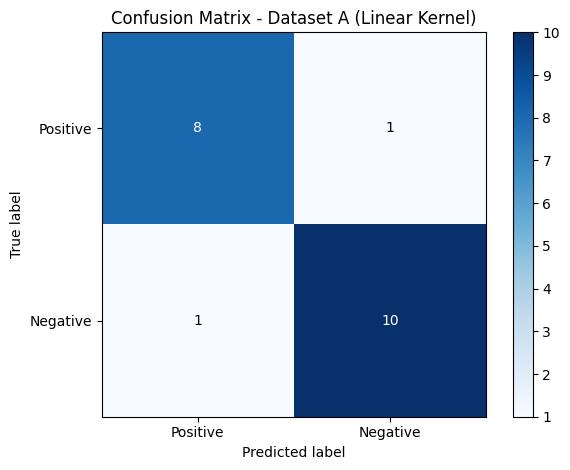

Classification Report: Dataset A (Linear Kernel)
Accuracy:  0.9000
Precision: 0.9091
Recall:    0.9091
F1 Score:  0.9091
AUC:       0.9798
Hinge Loss: 0.1967


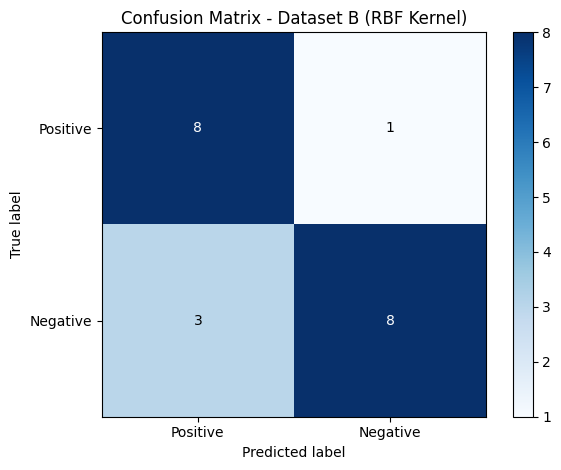

Classification Report: Dataset B (RBF Kernel)
Accuracy:  0.8000
Precision: 0.8889
Recall:    0.7273
F1 Score:  0.8000
AUC:       0.9192
Hinge Loss: 0.4320


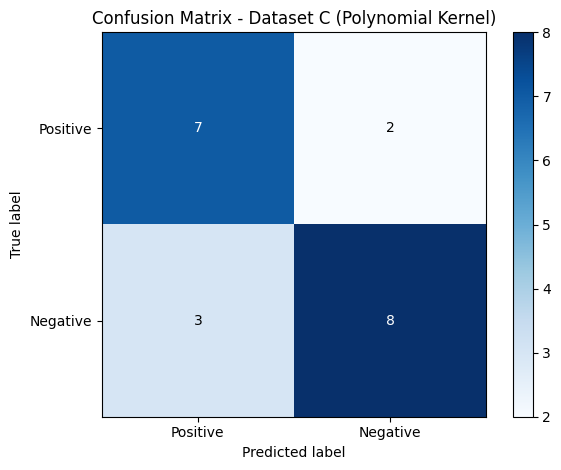

Classification Report: Dataset C (Polynomial Kernel)
Accuracy:  0.7500
Precision: 0.8000
Recall:    0.7273
F1 Score:  0.7619
AUC:       0.8889
Hinge Loss: 0.5119


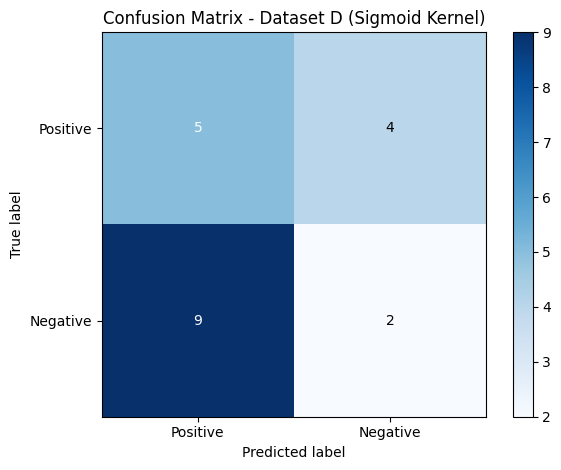

Classification Report: Dataset D (Sigmoid Kernel)
Accuracy:  0.3500
Precision: 0.3333
Recall:    0.1818
F1 Score:  0.2353
AUC:       0.4848
Hinge Loss: 1.7471


In [ ]:
#-------------------------------------------Linear-----------------------------------------------------------#
# Visualize results of linear kernel on Dataset A
y_pred_A = svm_linear.predict(X_test_A)
cm_A = calculate_confusion_matrix(y_test_A, y_pred_A)
plot_confusion_matrix(cm_A, "Confusion Matrix - Dataset A (Linear Kernel)")
print_classification_report(y_test_A, y_pred_A, "Dataset A (Linear Kernel)")

auc_value = calculate_roc_auc(y_test_A, svm_linear.decision_function(X_test_A))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_A = svm_linear.hinge_loss(X_test_A, y_test_A)
print(f"Hinge Loss: {test_hinge_loss_A:.4f}")
#-------------------------------------------RBF--------------------------------------------------------------#
# Visualize results for RBF kernel on Dataset B
y_pred_B = svm_rbf.predict(X_test_B)
cm_B = calculate_confusion_matrix(y_test_B, y_pred_B)
plot_confusion_matrix(cm_B, "Confusion Matrix - Dataset B (RBF Kernel)")
print_classification_report(y_test_B, y_pred_B, "Dataset B (RBF Kernel)")

auc_value = calculate_roc_auc(y_test_B, svm_rbf.decision_function(X_test_B))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_B = svm_rbf.hinge_loss(X_test_B, y_test_B)
print(f"Hinge Loss: {test_hinge_loss_B:.4f}")

#-------------------------------------------Polynomial--------------------------------------------------------#
# Visualize results for Polynomial kernel on Dataset B
y_pred_C = svm_polynomial.predict(X_test_C)
cm_C = calculate_confusion_matrix(y_test_C, y_pred_C)
plot_confusion_matrix(cm_C, "Confusion Matrix - Dataset C (Polynomial Kernel)")
print_classification_report(y_test_C, y_pred_C, "Dataset C (Polynomial Kernel)")

auc_value = calculate_roc_auc(y_test_C, svm_polynomial.decision_function(X_test_C))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_C = svm_polynomial.hinge_loss(X_test_C, y_test_C)
print(f"Hinge Loss: {test_hinge_loss_C:.4f}")
#-------------------------------------------Sigmoid-----------------------------------------------------------#
# Visualize results for Sigmoid on Dataset B
y_pred_D = svm_sigmoid.predict(X_test_D)
cm_D = calculate_confusion_matrix(y_test_D, y_pred_D)
plot_confusion_matrix(cm_D, "Confusion Matrix - Dataset D (Sigmoid Kernel)")
print_classification_report(y_test_D, y_pred_D, "Dataset D (Sigmoid Kernel)")

auc_value = calculate_roc_auc(y_test_D, svm_sigmoid.decision_function(X_test_D))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_D = svm_sigmoid.hinge_loss(X_test_D, y_test_D)
print(f"Hinge Loss: {test_hinge_loss_D:.4f}")

## Test 3: Applying models on dataset with noise(0.2) with hyperparamter tuning via Grid Search


Best C: 0.01, Best Gamma: None, Best Degree: None with accuracy: 0.9


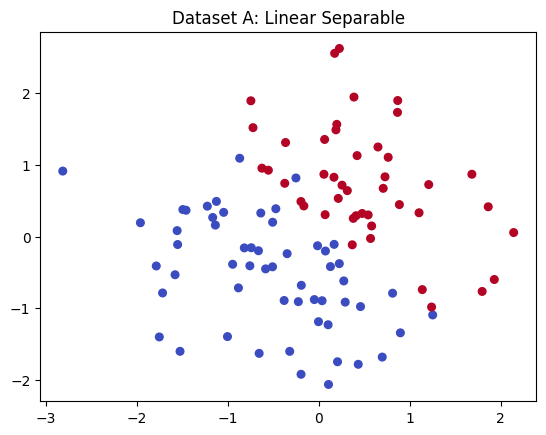

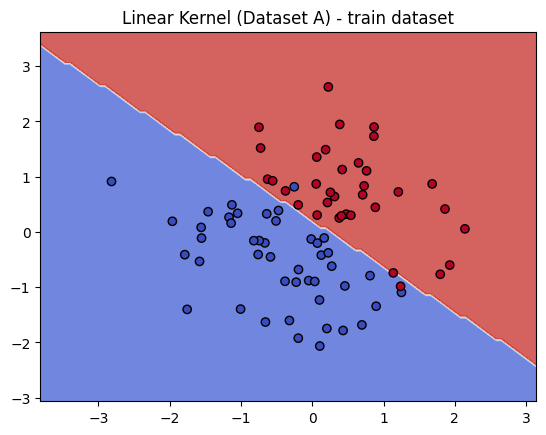

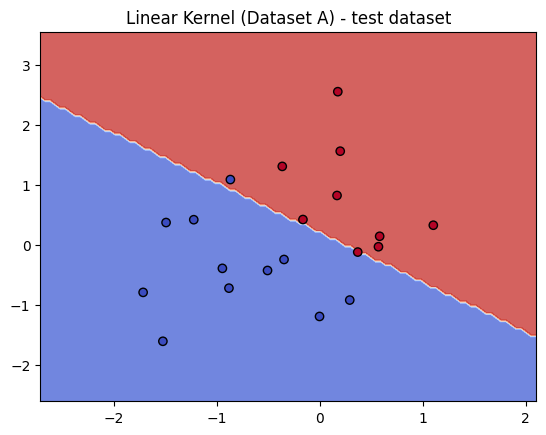

****************************************************************************************************************************************************************
Best C: 10.0, Best Gamma: 0.03162277660168379, Best Degree: None with accuracy: 0.85


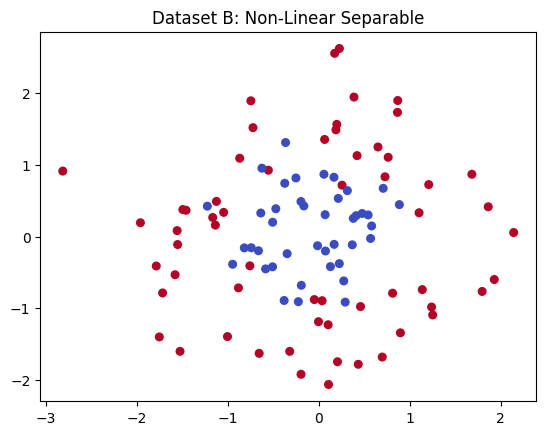

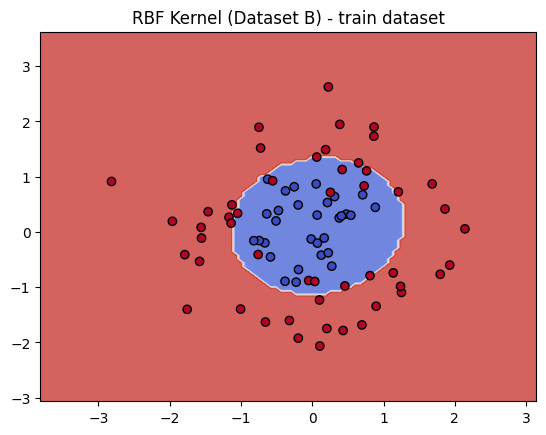

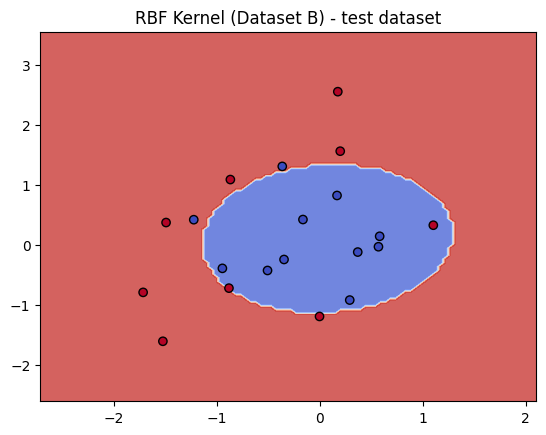

****************************************************************************************************************************************************************
Best C: 0.01, Best Gamma: None, Best Degree: 3 with accuracy: 0.85


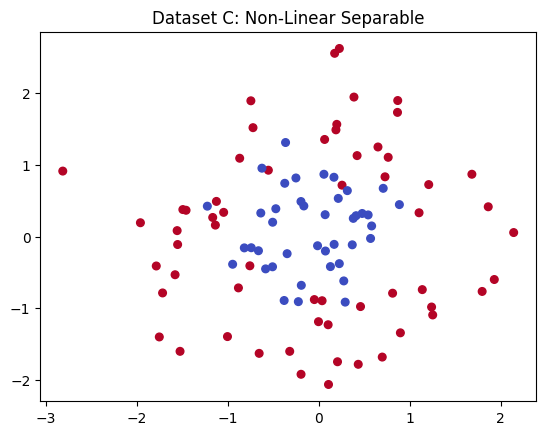

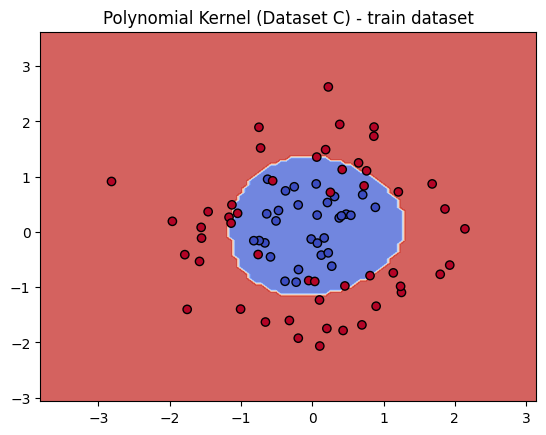

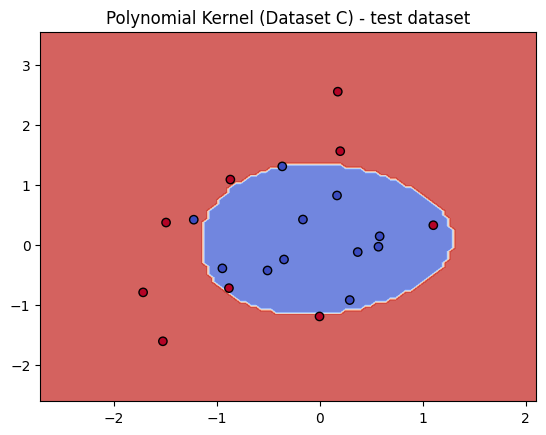

****************************************************************************************************************************************************************
Best C: 10.0, Best Gamma: None, Best Degree: None with accuracy: 0.5


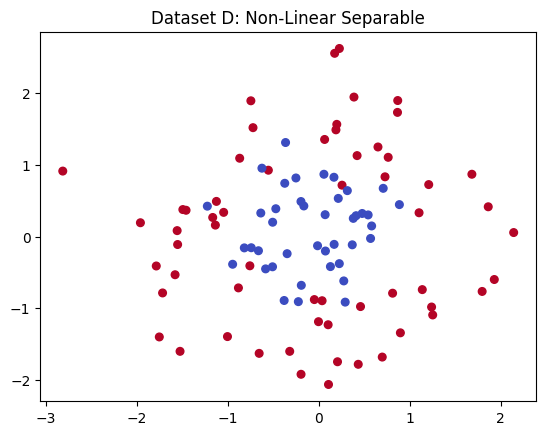

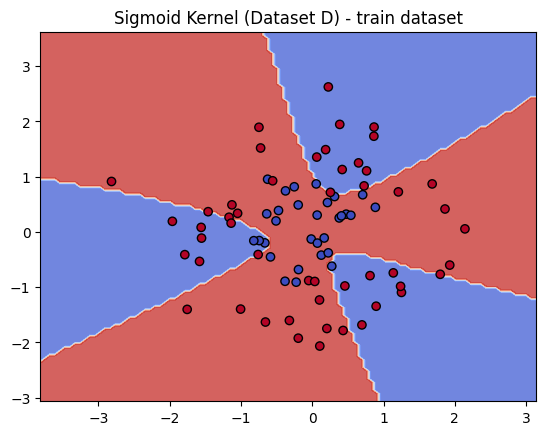

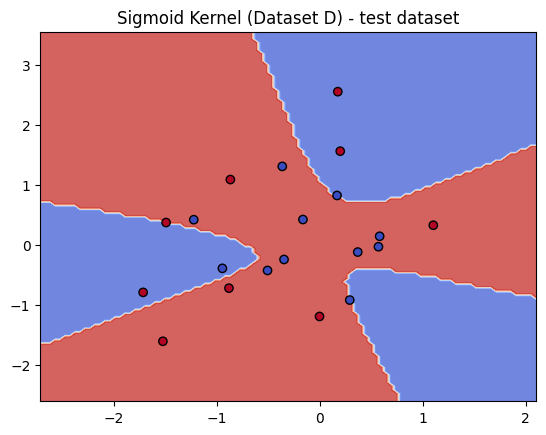

In [ ]:
# regularisation term's range for tuning
C_range = [0.01, 100]

#-------------------------------------------Linear-----------------------------------------------------------#
# Dataset A: Linear separable
X_A, y_A = generate_data(linear=True, noise_level=0.2)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A)

#Peform Grid Search to find the Best C for Linear Kernel
best_C_A, _, _, _A= grid_search_svm(X_train_A, y_train_A, X_test_A, y_test_A, 'linear', C_range=C_range, num_samples=5)

# Train SVM on Dataset A (Linear) using SGD
svm_linear = SVM(kernel='linear', C=best_C_A)
svm_linear.fit(X_train_A, y_train_A)

# Generate and plot Dataset A (Linear)
X_A, y_A = generate_data(linear=True, noise_level=0.2)
plot_dataset(X_A, y_A, title="Dataset A: Linear Separable")

# Plot decision boundary for Dataset A
plot_decision_boundary(svm_linear, X_train_A, y_train_A, title="Linear Kernel (Dataset A) - train dataset")

# Plot decision boundary for Dataset A (Linear)
plot_decision_boundary(svm_linear, X_test_A, y_test_A, title="Linear Kernel (Dataset A) - test dataset")

print("*" * 160)
#--------------------------------------------RBF-------------------------------------------------------------#

# Dataset B: Non-linear separable
X_B, y_B = generate_data(linear=False, noise_level=0.2)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B)

# Perform Grid Search to find the best C for RBF kernel
gamma_range = [0.001, 1]
best_C_B, best_gamma_B, _, _B = grid_search_svm(X_train_B, y_train_B, X_test_B, y_test_B, kernel='rbf', C_range=C_range, gamma_range=gamma_range, num_samples=5)

# Train SVM on Dataset B (Non-linear) using SMO with RBF kernel
svm_rbf = SVM(kernel='rbf', C=best_C_B, gamma=best_gamma_B)
svm_rbf.fit(X_train_B, y_train_B)

# Generate and plot Dataset B (Non-Linear)
X_B, y_B = generate_data(linear=False, noise_level=0.2)
plot_dataset(X_B, y_B, title="Dataset B: Non-Linear Separable")

# Plot decision boundary for Dataset B
plot_decision_boundary(svm_rbf, X_train_B, y_train_B, title="RBF Kernel (Dataset B) - train dataset")

# Plot decision boundary for Dataset B (RBF Kernel)
plot_decision_boundary(svm_rbf, X_test_B, y_test_B, title="RBF Kernel (Dataset B) - test dataset")

print("*" * 160)
#--------------------------------------------Polynomial--------------------------------------------------------#

# Dataset C: Non-linear separable
X_C, y_C = generate_data(linear=False, noise_level=0.2)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C)

# Perform Grid Search to find the best C for Polynomial kernel
degree_range = [2, 5]
best_C_C, _, best_degree_C, _C = grid_search_svm(X_train_C, y_train_C, X_test_C, y_test_C, kernel='polynomial', C_range=C_range, degree_range=degree_range, num_samples=5)

# Train SVM on Dataset B (Non-linear) using SMO with Polynomial kernel
svm_polynomial = SVM(kernel='polynomial', C=best_C_C, degree=best_degree_C)
svm_polynomial.fit(X_train_C, y_train_C)

# Generate and plot Dataset B (Non-Linear)
X_C, y_C = generate_data(linear=False, noise_level=0.2)
plot_dataset(X_C, y_C, title="Dataset C: Non-Linear Separable")

# Plot decision boundary for Dataset B
plot_decision_boundary(svm_polynomial, X_train_C, y_train_C, title="Polynomial Kernel (Dataset C) - train dataset")

# Plot decision boundary for Dataset B (Polynomial Kernel)
plot_decision_boundary(svm_polynomial, X_test_C, y_test_C, title="Polynomial Kernel (Dataset C) - test dataset")

print("*" * 160)
#---------------------------------------------Sigmoid----------------------------------------------------------#

# Dataset D: Non-linear separable
X_D, y_D = generate_data(linear=False, noise_level=0.2)
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X_D, y_D)

# Perform Grid Search to find the best C for Sigmoid kernel
best_C_D, _, _, _D = grid_search_svm(X_train_D, y_train_D, X_test_D, y_test_D, kernel='sigmoid', C_range=C_range, num_samples=5)

# Train SVM on Dataset D (Non-linear) using SMO with Sigmoid kernel
svm_sigmoid = SVM(kernel='sigmoid', C=best_C_D)
svm_sigmoid.fit(X_train_D, y_train_D)

# Generate and plot Dataset D (Non-Linear)
X_D, y_D = generate_data(linear=False, noise_level=0.2)
plot_dataset(X_D, y_D, title="Dataset D: Non-Linear Separable")

# Plot decision boundary for Dataset D
plot_decision_boundary(svm_sigmoid, X_train_D, y_train_D, title="Sigmoid Kernel (Dataset D) - train dataset")

# Plot decision boundary for Dataset D (Sigmoid Kernel)
plot_decision_boundary(svm_sigmoid, X_test_D, y_test_D, title="Sigmoid Kernel (Dataset D) - test dataset")

**Visualise Classification Report and Confusion Matrix for kernels on selected test**

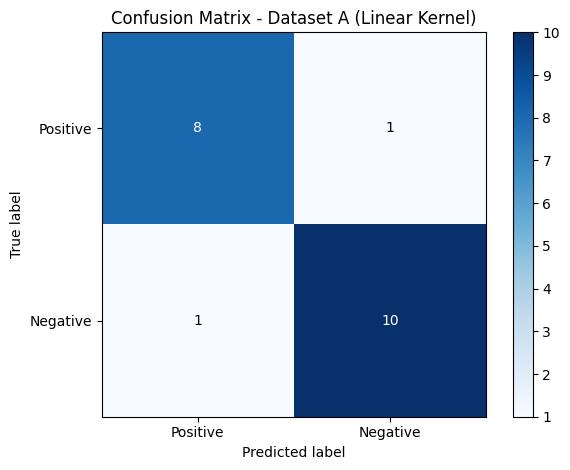

Classification Report: Dataset A (Linear Kernel)
Accuracy:  0.9000
Precision: 0.9091
Recall:    0.9091
F1 Score:  0.9091
AUC:       0.9798
Hinge Loss: 0.1967


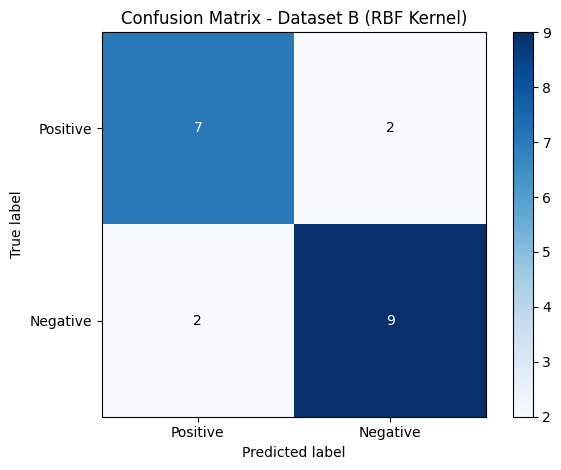

Classification Report: Dataset B (RBF Kernel)
Accuracy:  0.8000
Precision: 0.8182
Recall:    0.8182
F1 Score:  0.8182
AUC:       0.9192
Hinge Loss: 0.4975


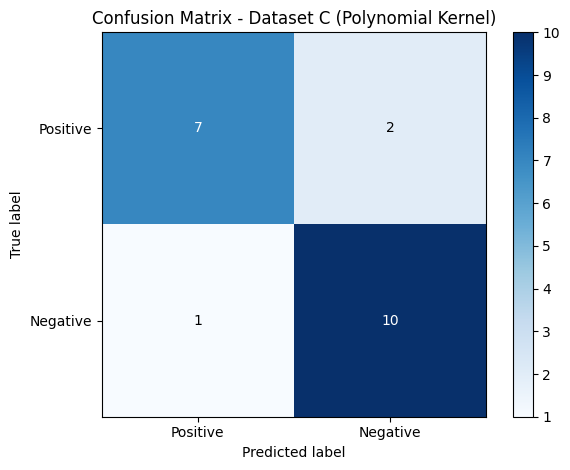

Classification Report: Dataset C (Polynomial Kernel)
Accuracy:  0.8500
Precision: 0.8333
Recall:    0.9091
F1 Score:  0.8696
AUC:       0.9394
Hinge Loss: 0.5327


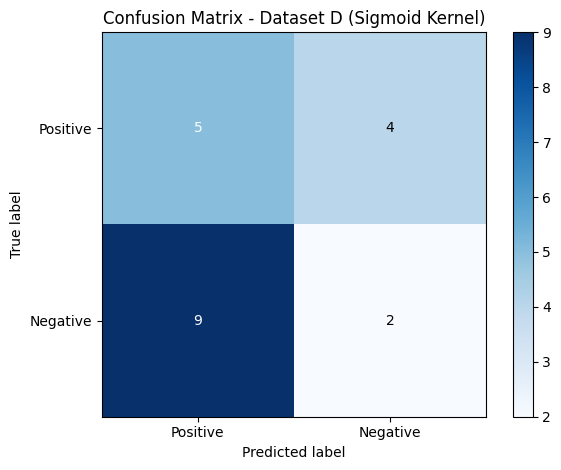

Classification Report: Dataset D (Sigmoid Kernel)
Accuracy:  0.3500
Precision: 0.3333
Recall:    0.1818
F1 Score:  0.2353
AUC:       0.5354
Hinge Loss: 12.3995


In [ ]:
#-------------------------------------------Linear-----------------------------------------------------------#
# Visualize results for lineart kernel on Dataset A
y_pred_A = svm_linear.predict(X_test_A)
cm_A = calculate_confusion_matrix(y_test_A, y_pred_A)
plot_confusion_matrix(cm_A, "Confusion Matrix - Dataset A (Linear Kernel)")
print_classification_report(y_test_A, y_pred_A, "Dataset A (Linear Kernel)")

auc_value = calculate_roc_auc(y_test_A, svm_linear.decision_function(X_test_A))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_A = svm_linear.hinge_loss(X_test_A, y_test_A)
print(f"Hinge Loss: {test_hinge_loss_A:.4f}")
#-------------------------------------------RBF--------------------------------------------------------------#
# Visualize results for RBF kernel on Dataset B
y_pred_B = svm_rbf.predict(X_test_B)
cm_B = calculate_confusion_matrix(y_test_B, y_pred_B)
plot_confusion_matrix(cm_B, "Confusion Matrix - Dataset B (RBF Kernel)")
print_classification_report(y_test_B, y_pred_B, "Dataset B (RBF Kernel)")

auc_value = calculate_roc_auc(y_test_B, svm_rbf.decision_function(X_test_B))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_B = svm_rbf.hinge_loss(X_test_B, y_test_B)
print(f"Hinge Loss: {test_hinge_loss_B:.4f}")

#-------------------------------------------Polynomial--------------------------------------------------------#
# Visualize results for polynomial kernel on Dataset B
y_pred_C = svm_polynomial.predict(X_test_C)
cm_C = calculate_confusion_matrix(y_test_C, y_pred_C)
plot_confusion_matrix(cm_C, "Confusion Matrix - Dataset C (Polynomial Kernel)")
print_classification_report(y_test_C, y_pred_C, "Dataset C (Polynomial Kernel)")

auc_value = calculate_roc_auc(y_test_C, svm_polynomial.decision_function(X_test_C))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_C = svm_polynomial.hinge_loss(X_test_C, y_test_C)
print(f"Hinge Loss: {test_hinge_loss_C:.4f}")
#-------------------------------------------Sigmoid-----------------------------------------------------------#
# Visualize results for sigmoid kernel on Dataset B
y_pred_D = svm_sigmoid.predict(X_test_D)
cm_D = calculate_confusion_matrix(y_test_D, y_pred_D)
plot_confusion_matrix(cm_D, "Confusion Matrix - Dataset D (Sigmoid Kernel)")
print_classification_report(y_test_D, y_pred_D, "Dataset D (Sigmoid Kernel)")

auc_value = calculate_roc_auc(y_test_D, svm_sigmoid.decision_function(X_test_D))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_D = svm_sigmoid.hinge_loss(X_test_D, y_test_D)
print(f"Hinge Loss: {test_hinge_loss_D:.4f}")

## Test 4: Applying models on dataset with noise(0.2) with hyperparameter tuning via Random Search



Best C: 3.330334668247093, Best Gamma: None, Best Degree: None with accuracy: 0.9


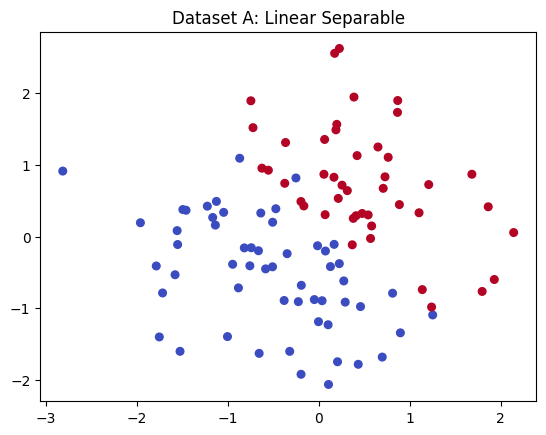

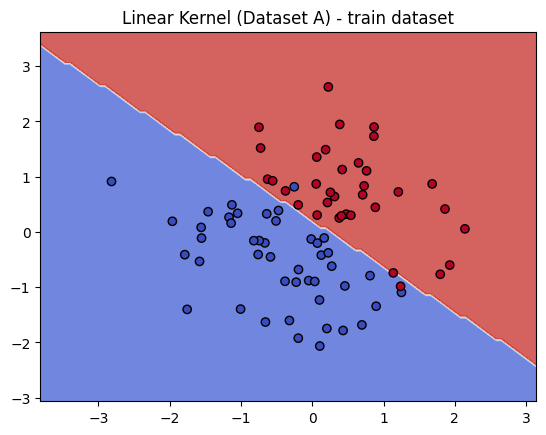

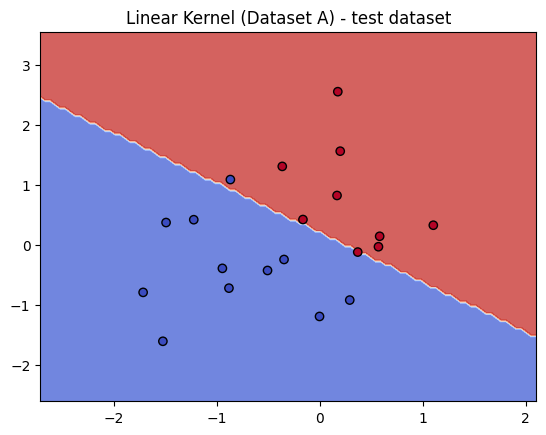

****************************************************************************************************************************************************************
Best C: 99.3624543643551, Best Gamma: 0.13727841744727975, Best Degree: None with accuracy: 0.75


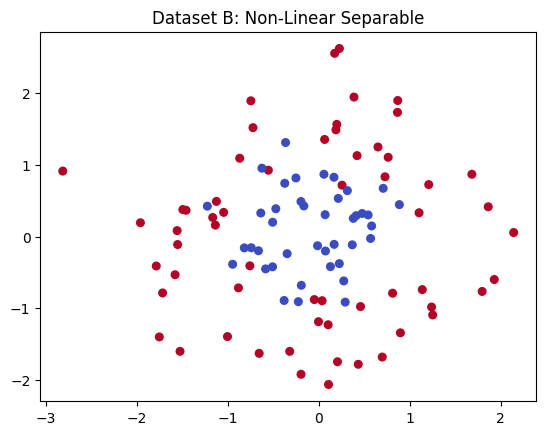

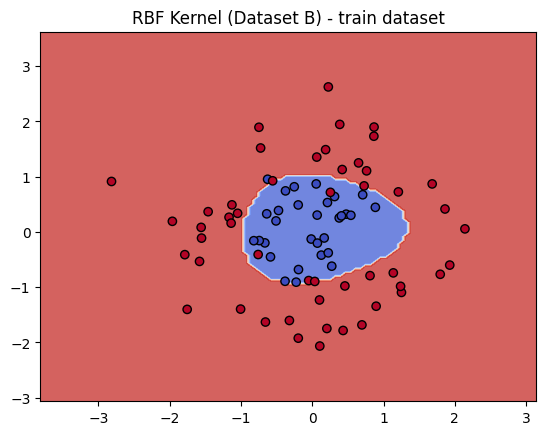

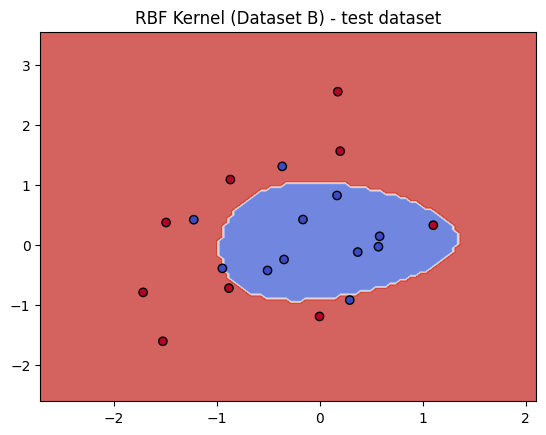

****************************************************************************************************************************************************************
Best C: 55.992701794860096, Best Gamma: None, Best Degree: 5 with accuracy: 0.8


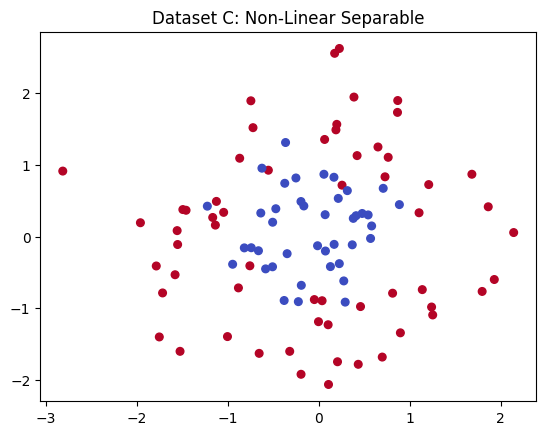

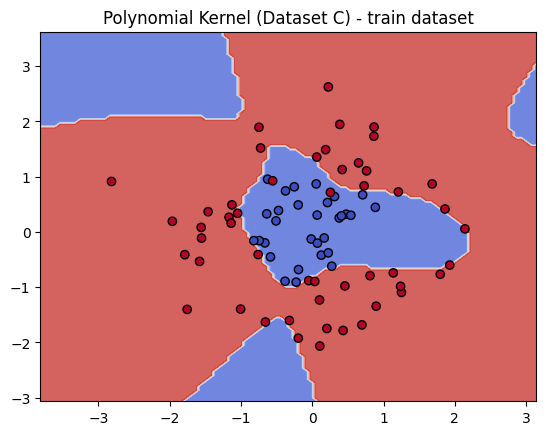

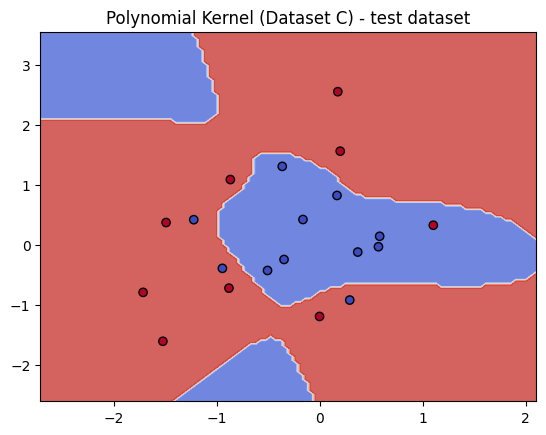

****************************************************************************************************************************************************************
Best C: 79.23722844005592, Best Gamma: None, Best Degree: None with accuracy: 0.5


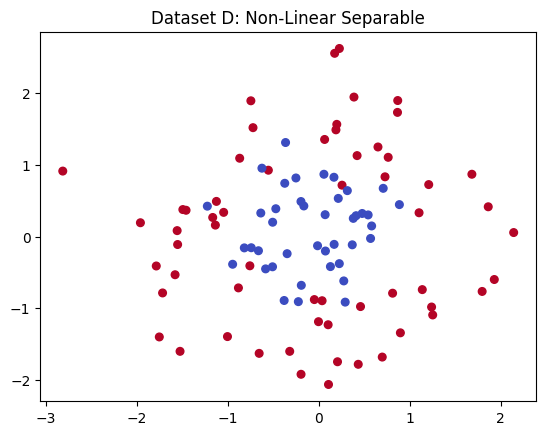

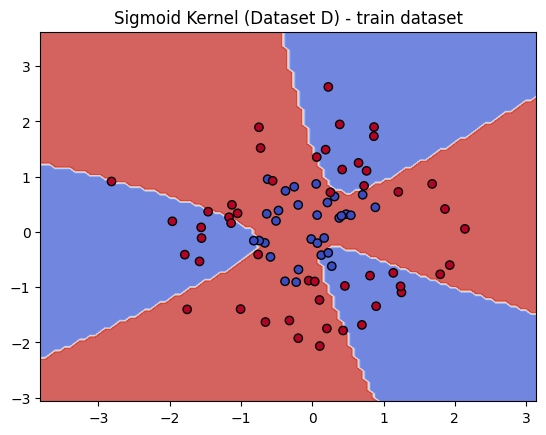

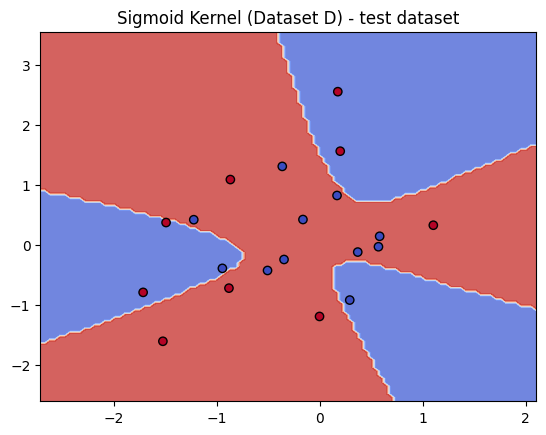

In [ ]:
#regularisaiton term's range for tuning
C_range = [0.01, 100]

#-------------------------------------------Linear-----------------------------------------------------------#
# Dataset A: Linear separable
X_A, y_A = generate_data(linear=True, noise_level=0.2)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A)

#Peform Random Search to find the Best C for Linear Kernel
best_C_A, _, _, _A= random_search_svm(X_train_A, y_train_A, X_test_A, y_test_A, kernel='linear', C_range=C_range, num_samples=5)

# Train SVM on Dataset A (Linear) using SGD
svm_linear = SVM(kernel='linear', C=best_C_A)
svm_linear.fit(X_train_A, y_train_A)

# Generate and plot Dataset A (Linear)
X_A, y_A = generate_data(linear=True, noise_level=0.2)
plot_dataset(X_A, y_A, title="Dataset A: Linear Separable")

# Plot decision boundary for Dataset A
plot_decision_boundary(svm_linear, X_train_A, y_train_A, title="Linear Kernel (Dataset A) - train dataset")

# Plot decision boundary for Dataset A (Linear)
plot_decision_boundary(svm_linear, X_test_A, y_test_A, title="Linear Kernel (Dataset A) - test dataset")

print("*" * 160)
#--------------------------------------------RBF-------------------------------------------------------------#
# Dataset B: Non-linear separable
X_B, y_B = generate_data(linear=False, noise_level=0.2)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B)

#Peform Random Search to find the Best C, gamma for RBF Kernel
gamma_range = [0.001, 1]
best_C_B, best_gamma_B, _, _B= random_search_svm(X_train_B, y_train_B, X_test_B, y_test_B, kernel='rbf', C_range=C_range, gamma_range=gamma_range, num_samples=5)

# Train SVM on Dataset B (Non-linear) using SMO with RBF kernel
svm_rbf = SVM(kernel='rbf', C=best_C_B, gamma=best_gamma_B)
svm_rbf.fit(X_train_B, y_train_B)

# Generate and plot Dataset B (Non-Linear)
X_B, y_B = generate_data(linear=False, noise_level=0.2)
plot_dataset(X_B, y_B, title="Dataset B: Non-Linear Separable")

# Plot decision boundary for Dataset B
plot_decision_boundary(svm_rbf, X_train_B, y_train_B, title="RBF Kernel (Dataset B) - train dataset")

# Plot decision boundary for Dataset B (RBF Kernel)
plot_decision_boundary(svm_rbf, X_test_B, y_test_B, title="RBF Kernel (Dataset B) - test dataset")

print("*" * 160)
#--------------------------------------------Polynomial--------------------------------------------------------#

# Dataset C: Non-linear separable
X_C, y_C = generate_data(linear=False, noise_level=0.2)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C)

#Peform Random Search to find the Best C, degree for Polynomial Kernel
degree_range = [2, 5]
best_C_C, _, best_degree_C, _C= random_search_svm(X_train_C, y_train_C, X_test_C, y_test_C, kernel='polynomial', C_range=C_range, degree_range=degree_range, num_samples=5)

# Train SVM on Dataset B (Non-linear) using SMO with polynomial kernel
svm_polynomial = SVM(kernel='polynomial', C=best_C_C, degree=best_degree_C)
svm_polynomial.fit(X_train_C, y_train_C)

# Generate and plot Dataset B (Non-Linear)
X_C, y_C = generate_data(linear=False, noise_level=0.2)
plot_dataset(X_C, y_C, title="Dataset C: Non-Linear Separable")

# Plot decision boundary for Dataset B
plot_decision_boundary(svm_polynomial, X_train_C, y_train_C, title="Polynomial Kernel (Dataset C) - train dataset")

# Plot decision boundary for Dataset B (polynomial Kernel)
plot_decision_boundary(svm_polynomial, X_test_C, y_test_C, title="Polynomial Kernel (Dataset C) - test dataset")

print("*" * 160)
#---------------------------------------------Sigmoid----------------------------------------------------------#

# Dataset D: Non-linear separable
X_D, y_D = generate_data(linear=False, noise_level=0.2)
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X_D, y_D)

#Peform Random Search to find the Best C for sigmoid Kernel
best_C_D, _, _, _D= random_search_svm(X_train_D, y_train_D, X_test_D, y_test_D,
                                      kernel='sigmoid', C_range=C_range, num_samples=5)

# Train SVM on Dataset D (Non-linear) using SMO with sigmoid kernel
svm_sigmoid = SVM(kernel='sigmoid', C=best_C_D)
svm_sigmoid.fit(X_train_D, y_train_D)

# Generate and plot Dataset D (Non-Linear)
X_D, y_D = generate_data(linear=False, noise_level=0.2)
plot_dataset(X_D, y_D, title="Dataset D: Non-Linear Separable")

# Plot decision boundary for Dataset D
plot_decision_boundary(svm_sigmoid, X_train_D, y_train_D, title="Sigmoid Kernel (Dataset D) - train dataset")

# Plot decision boundary for Dataset D (Sigmoid Kernel)
plot_decision_boundary(svm_sigmoid, X_test_D, y_test_D, title="Sigmoid Kernel (Dataset D) - test dataset")

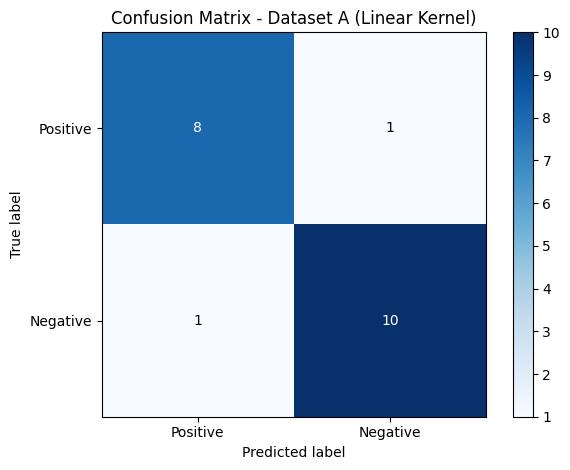

Classification Report: Dataset A (Linear Kernel)
Accuracy:  0.9000
Precision: 0.9091
Recall:    0.9091
F1 Score:  0.9091
AUC:       0.9798
Hinge Loss: 0.1967


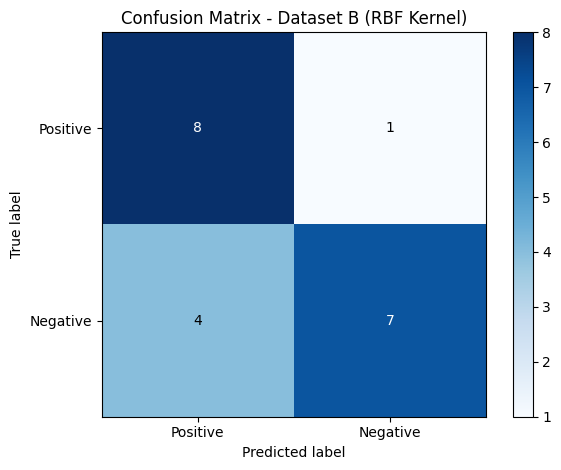

Classification Report: Dataset B (RBF Kernel)
Accuracy:  0.7500
Precision: 0.8750
Recall:    0.6364
F1 Score:  0.7368
AUC:       0.8990
Hinge Loss: 0.5064


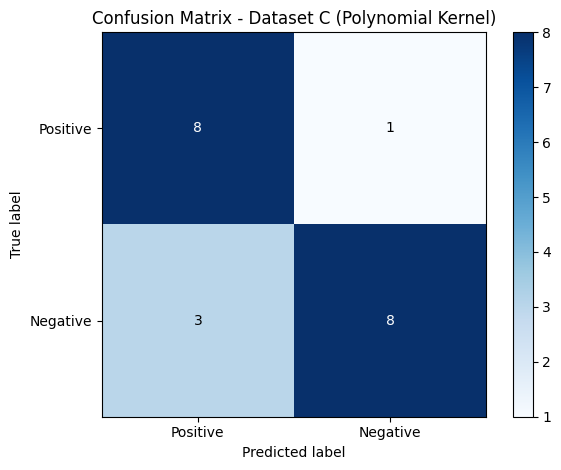

Classification Report: Dataset C (Polynomial Kernel)
Accuracy:  0.8000
Precision: 0.8889
Recall:    0.7273
F1 Score:  0.8000
AUC:       0.8384
Hinge Loss: 2.0680


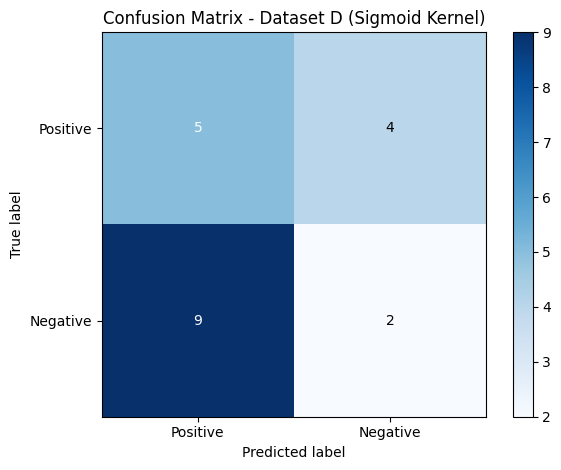

Classification Report: Dataset D (Sigmoid Kernel)
Accuracy:  0.3500
Precision: 0.3333
Recall:    0.1818
F1 Score:  0.2353
AUC:       0.5152
Hinge Loss: 92.3505


In [ ]:
#-------------------------------------------Linear-----------------------------------------------------------#
# Visualize results for linear kernel on Dataset A
y_pred_A = svm_linear.predict(X_test_A)
cm_A = calculate_confusion_matrix(y_test_A, y_pred_A)
plot_confusion_matrix(cm_A, "Confusion Matrix - Dataset A (Linear Kernel)")
print_classification_report(y_test_A, y_pred_A, "Dataset A (Linear Kernel)")

auc_value = calculate_roc_auc(y_test_A, svm_linear.decision_function(X_test_A))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_A = svm_linear.hinge_loss(X_test_A, y_test_A)
print(f"Hinge Loss: {test_hinge_loss_A:.4f}")
#-------------------------------------------RBF--------------------------------------------------------------#
# Visualize results for RBF kernel on Dataset B
y_pred_B = svm_rbf.predict(X_test_B)
cm_B = calculate_confusion_matrix(y_test_B, y_pred_B)
plot_confusion_matrix(cm_B, "Confusion Matrix - Dataset B (RBF Kernel)")
print_classification_report(y_test_B, y_pred_B, "Dataset B (RBF Kernel)")

auc_value = calculate_roc_auc(y_test_B, svm_rbf.decision_function(X_test_B))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_B = svm_rbf.hinge_loss(X_test_B, y_test_B)
print(f"Hinge Loss: {test_hinge_loss_B:.4f}")

#-------------------------------------------Polynomial--------------------------------------------------------#
# Visualize results for polynomial kernel on Dataset B
y_pred_C = svm_polynomial.predict(X_test_C)
cm_C = calculate_confusion_matrix(y_test_C, y_pred_C)
plot_confusion_matrix(cm_C, "Confusion Matrix - Dataset C (Polynomial Kernel)")
print_classification_report(y_test_C, y_pred_C, "Dataset C (Polynomial Kernel)")

auc_value = calculate_roc_auc(y_test_C, svm_polynomial.decision_function(X_test_C))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_C = svm_polynomial.hinge_loss(X_test_C, y_test_C)
print(f"Hinge Loss: {test_hinge_loss_C:.4f}")
#-------------------------------------------Sigmoid-----------------------------------------------------------#
# Visualize results for Sigmoid kernel on Dataset B
y_pred_D = svm_sigmoid.predict(X_test_D)
cm_D = calculate_confusion_matrix(y_test_D, y_pred_D)
plot_confusion_matrix(cm_D, "Confusion Matrix - Dataset D (Sigmoid Kernel)")
print_classification_report(y_test_D, y_pred_D, "Dataset D (Sigmoid Kernel)")

auc_value = calculate_roc_auc(y_test_D, svm_sigmoid.decision_function(X_test_D))
print(f"AUC:       {auc_value:.4f}")

test_hinge_loss_D = svm_sigmoid.hinge_loss(X_test_D, y_test_D)
print(f"Hinge Loss: {test_hinge_loss_D:.4f}")

# Final Findings

### Key
* The **darker grey cell** in the top row represents the linear kernel on test on the linear separable dataset.
* The **Lighter grey cells** in the bottom 3 rows represent the nonlinear kernels tested on the nonlinear separated data.
* The **coloured highlighted cells** represent the **best** performing **kernels** during each test



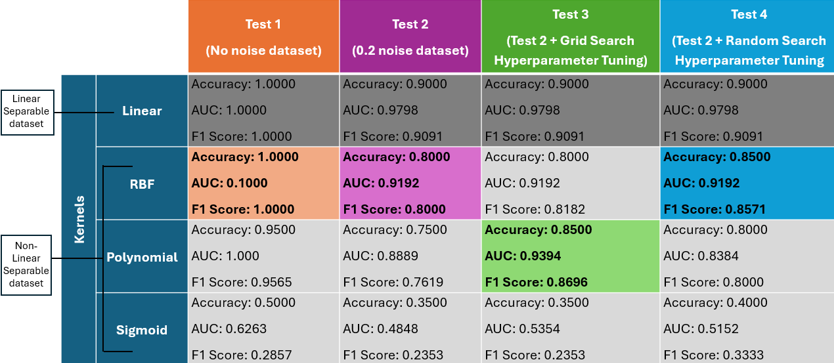

* Noise consistently reduced model performance across all kernels, as shown by the drop from test 1 to test 2.
* Hyperparameter tuning in tests 3 and 4 improved or maintained performance compared to test 2.
* The RBF kernel performed best overall, except in test 3 where the polynomial kernel outperformed it.
* The linear kernel performed perfectly on the noise-free dataset and showed no change across tests with noise.
* The sigmoid kernel consistently underperformed, likely due to the chosen circular dataset, which would better suit a XOR dataset.
* Both grid search and random search yielded similar improvements from hyperparameter tuning.

### Potential for future/further study
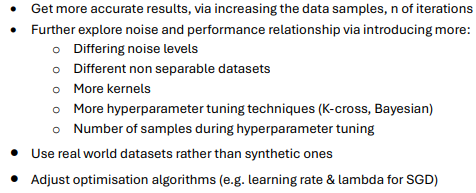